## 3.4 一般化線形モデル：ロジスティック回帰モデル

In [4]:
import pandas as pd
%matplotlib inline

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy import stats
import seaborn as sns

sns.set()

### 3.4.1 モデル概要

$$
\begin{align}
    y_n | \theta_n \sim \text{Bern}(y_n | \theta_n) = \theta_n^{y_n}(1 - \theta_n)^{(1-y_n)} \\
    \theta_n = \text{sigmoid}(w_1 x_n + w_2)
\end{align}
$$

シグモイド関数が逆リンク関数として用いられる. シグモイド関数はロジット関数の逆関数である.

$$
\begin{align}
    \text{sigmoid}(\alpha) = \frac{1}{1 - \exp{(\alpha)}}, \ \alpha \in \mathbb{R} \\
    \text{logit}(\beta) = \log{\biggl( \frac{\beta}{1 - \beta} \biggr)}, \ \beta \in (0, 1)
\end{align}
$$

### 3.2.2 実装

$$
\begin{align*}
    y_n | \theta_n \sim \text{Bern}(y_n | \theta_n) = \theta_n^{y_n}(1 - \theta_n)^{(1-y_n)} \\
    \text{logit}(\theta_n) = w_1 x_{n,1} + w_2 x_{n,2} + w_3
\end{align*}
$$


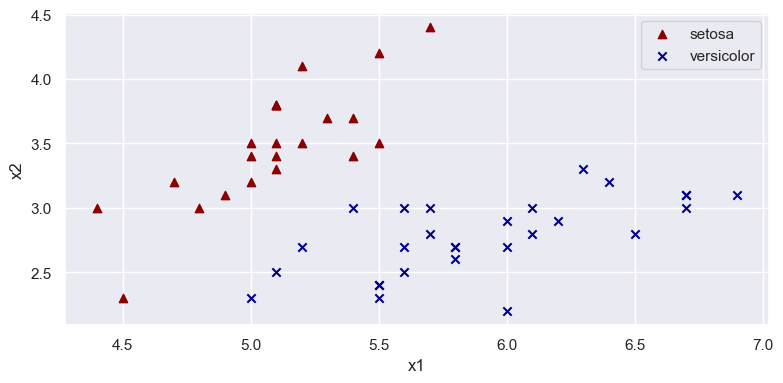

In [6]:
# iris データセットの読み込み
iris_dataset = sns.load_dataset("iris")

# データ数
N = 50

# setosa と versicolor のみ抽出
iris_dataset_2species = iris_dataset[iris_dataset["species"].isin(["setosa", "versicolor"])].copy()

# 使用するデータをサンプリング
iris_dataset_use = iris_dataset_2species.sample(N, random_state=1)

# 説明変数
x_data = iris_dataset_use[["sepal_length", "sepal_width"]].copy().values

# バイアス項の追加
x_data_add_bias = np.concatenate([x_data, np.ones((N, 1))], axis=1)

# 目的変数
y_data = pd.Categorical(iris_dataset_use["species"]).codes

# データを species で分割して可視化
x_data_set = x_data[y_data == 0]
x_data_ves = x_data[y_data == 1]

fig, ax = plt.subplots(figsize=(8, 4))
ax.scatter(x=x_data_set[:, 0], y=x_data_set[:, 1], color="darkred", marker="^", label="setosa")
ax.scatter(x=x_data_ves[:, 0], y=x_data_ves[:, 1], color="darkblue", marker="x", label="versicolor")

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
with pm.Model() as model:
    # 説明変数
    x = pm.Data("x", x_data_add_bias)

    # 推論パラメータの事前分布
    w = pm.Normal("w", mu=0.0, sigma=1.0, shape=3)

    # 尤度関数
    y = pm.Bernoulli("y", logit_p=w.dot(x.T), observed=y_data)

In [9]:
with model:
    # MCMC による推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, random_seed=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w]


/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8927918314410027, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>]], dtype=object)

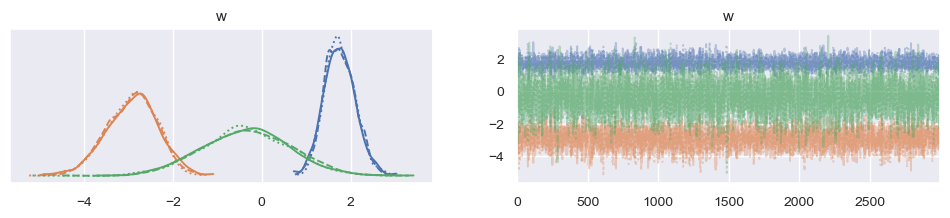

In [10]:
az.plot_trace(trace)

In [11]:
for var_info in az.rhat(trace).values():
    print(var_info.name, var_info.values.round(3), sep=" ")

w [1.001 1.002 1.001]


array([<AxesSubplot:title={'center':'w\n0'}>,
       <AxesSubplot:title={'center':'w\n1'}>,
       <AxesSubplot:title={'center':'w\n2'}>], dtype=object)

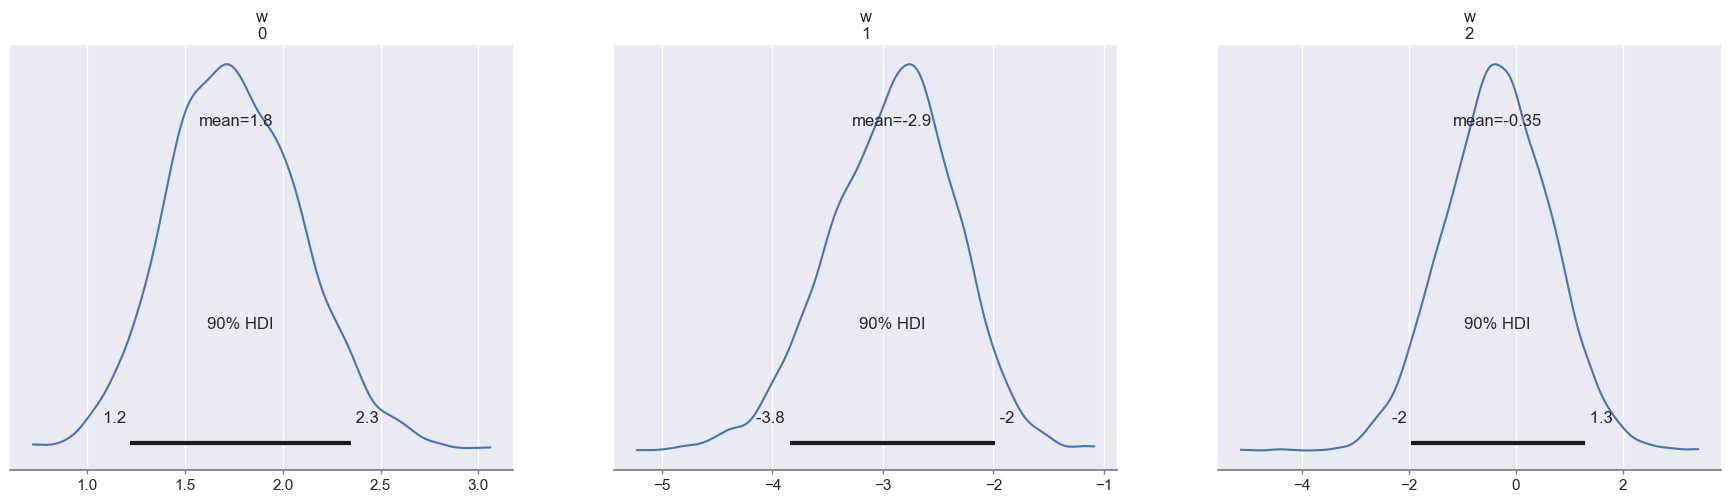

In [12]:
az.plot_posterior(trace, hdi_prob=0.90)

In [18]:
trace.posterior["w"].values.reshape(9000, 3)

array([[ 1.35630446, -2.28717502, -0.46478938],
       [ 1.35630446, -2.28717502, -0.46478938],
       [ 1.51148495, -2.46345877,  0.04882191],
       ...,
       [ 1.77541888, -2.82353326, -1.10227736],
       [ 1.68589489, -2.724934  , -0.05044141],
       [ 1.93174354, -3.65338891,  0.80435486]])

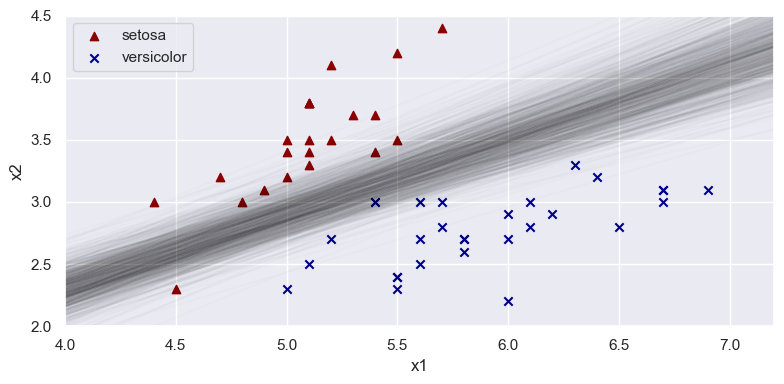

In [19]:
# サンプルの取り出し (チェーン 3 つ分を結合)
w_mcmc_samples = trace.posterior["w"].values.reshape(9000, 3)

# 次元ごとに取り出し
w1_samples = w_mcmc_samples[:, 0]
w2_samples = w_mcmc_samples[:, 1]
w3_samples = w_mcmc_samples[:, 2]

fig, ax = plt.subplots(figsize=(8, 4))

# サンプルデータ
ax.scatter(x=x_data_set[:, 0], y=x_data_set[:, 1], color="darkred", marker="^", label="setosa")
ax.scatter(x=x_data_ves[:, 0], y=x_data_ves[:, 1], color="darkblue", marker="x", label="versicolor")

N_new = 10
x1 = np.linspace(4.0, 7.2, N_new)
for i in range(0, 9000, 10):
    # x1 に対して theta = 0.5 となる x2
    x2 = -w3_samples[i] / w2_samples[i] - w1_samples[i] / w2_samples[i] * x1
    ax.plot(x1, x2, alpha=0.01, color="black")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_xlim(4.0, 7.2)
ax.set_ylim(2.0, 4.5)
ax.legend()
plt.tight_layout()
plt.show()

/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/var/folders/rj/lgv8bfcx63q2n09cr87df55c0000gn/T/ipykernel_49855/3237895253.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(contourf, ax=ax)


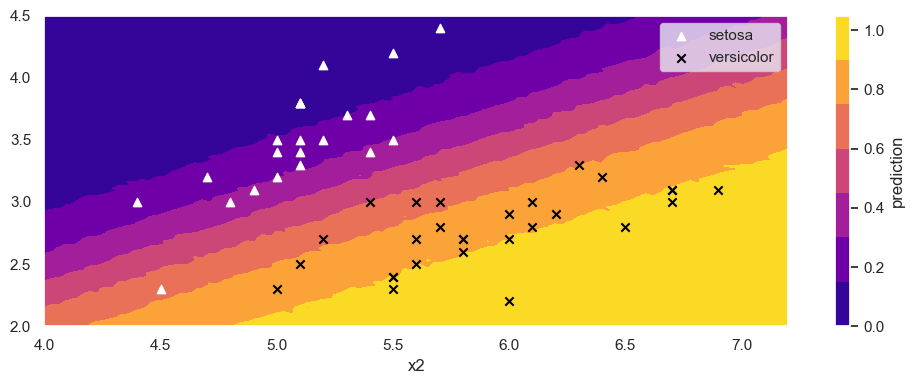

In [26]:
# 2 次元のグリッド状データ作成 (100 x 100)
N_new = 100
x1_linspace = np.linspace(4.0, 7.2, N_new)
x2_linspace = np.linspace(2.0, 4.5, N_new)
x1_grid, x2_grid = np.meshgrid(x1_linspace, x2_linspace)
x_new = np.array([[x1, x2] for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())])
x_new_add_bias = np.concatenate([x_new, np.ones((N_new ** 2, 1))], axis=1)

with model:
    # 検証用データをモデルに入力
    pm.set_data({"x": x_new_add_bias})

    # 予測分布からサンプリング
    pred = pm.sample_posterior_predictive(trace, samples=3000, random_seed=1)

y_pred_samples = pred["y"]

fig, ax = plt.subplots(figsize=(10, 4))
contourf = ax.contourf(x1_grid, x2_grid, y_pred_samples.mean(axis=0).reshape(N_new, N_new), cmap="plasma")

# サンプルデータ
ax.scatter(x=x_data_set[:, 0], y=x_data_set[:, 1], color="white", marker="^", label="setosa")
ax.scatter(x=x_data_ves[:, 0], y=x_data_ves[:, 1], color="black", marker="x", label="versicolor")
ax.set_xlabel("x1")
ax.set_xlabel("x2")
ax.legend()
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label("prediction")
cbar.set_ticks(ticks=np.arange(0, 1.1, 0.2))
plt.tight_layout()
plt.show()